In [1]:
import numpy as np
import csv
import pandas as pd
import re
import collections
import matplotlib.pyplot as plt
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


## Get Training and Test Data

In [3]:
traindf=pd.read_csv('train.tsv', sep='\t')
print(traindf.head(5))
print("\nShape of train data: ",traindf.shape) 
print("\nColumn Names:" ,traindf.columns.values) # PhraseId, SentenceId, Phrase, Sentiment

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  

Shape of train data:  (156060, 4)

Column Names: ['PhraseId' 'SentenceId' 'Phrase' 'Sentiment']


In [4]:
testdf=pd.read_csv('test.tsv', sep='\t')
print(testdf.head(5))
print("\nShape of test data: ",testdf.shape) 
print("\nColumn Names:", testdf.columns.values) 

   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

Shape of test data:  (66292, 3)

Column Names: ['PhraseId' 'SentenceId' 'Phrase']


## Preprocess Text Data

In [5]:
def remove_stopwords(input_text):
    
        words = input_text.split() 
        #print(words)
        
        # convert to lower case
        low_words = [line.lower() for line in words]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [line.translate(table) for line in low_words]
    
        # remove remaining tokens that are not alphabetic
        words= [line for line in stripped if line.isalpha()]
        
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
    

In [6]:
traindf['Phrase'] = traindf['Phrase'].apply(remove_stopwords).apply(remove_mentions)
traindf['Phrase'].head()

0    series escapades demonstrating adage good goos...
1      series escapades demonstrating adage good goose
2                                               series
3                                                     
4                                               series
Name: Phrase, dtype: object

In [7]:
testdf['Phrase'] = testdf['Phrase'].apply(remove_stopwords).apply(remove_mentions)
testdf['Phrase'].head()

0    intermittently pleasing mostly routine effort
1    intermittently pleasing mostly routine effort
2                                                 
3    intermittently pleasing mostly routine effort
4           intermittently pleasing mostly routine
Name: Phrase, dtype: object

In [8]:
tk = Tokenizer(num_words=10000, split=" ")
tk.fit_on_texts(traindf['Phrase'])

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))

Fitted tokenizer on 156060 documents
10000 words in dictionary


In [9]:
train_seq = tk.texts_to_sequences(traindf['Phrase'])
test_seq = tk.texts_to_sequences(testdf['Phrase'])

print('"{}" is converted into {}'.format(traindf['Phrase'][0], train_seq[0]))

"series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story" is converted into [202, 5720, 6303, 10, 3358, 86, 10, 502, 463, 1874, 12, 7]


In [10]:
def one_hot_seq(seqs, nb_features = 10000):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train = one_hot_seq(train_seq)
X_test = one_hot_seq(test_seq)

print('"{}" is converted into {}'.format(train_seq[0], X_train[0]))

"[202, 5720, 6303, 10, 3358, 86, 10, 502, 463, 1874, 12, 7]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 11.0 features with a value of 1.


In [11]:
y_train = to_categorical(traindf['Sentiment'])

print('"{}" is converted into {}'.format(traindf['Sentiment'][0], y_train[0]))

"1" is converted into [0. 1. 0. 0. 0.]


In [12]:
print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (156060, 10000)
Shape of y_train: (156060, 5)
Shape of X_test: (66292, 10000)


## Neural Network

In [31]:
input_shape=X_train[0].shape
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 644,549
Trainable params: 644,549
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history=model.fit(X_train, y_train, epochs=15, batch_size=512,validation_split=0.2)

Train on 124848 samples, validate on 31212 samples
Epoch 1/15
124848/124848 [==============================] - 133s 1ms/step - loss: 0.4378 - acc: 0.8231 - val_loss: 0.4134 - val_acc: 0.8296
Epoch 2/15
124848/124848 [==============================] - 92s 734us/step - loss: 0.3997 - acc: 0.8386 - val_loss: 0.4033 - val_acc: 0.8330
Epoch 3/15
124848/124848 [==============================] - 68s 545us/step - loss: 0.3904 - acc: 0.8411 - val_loss: 0.3973 - val_acc: 0.8335
Epoch 4/15
124848/124848 [==============================] - 122s 979us/step - loss: 0.3843 - acc: 0.8420 - val_loss: 0.3917 - val_acc: 0.8361
Epoch 5/15
124848/124848 [==============================] - 78s 624us/step - loss: 0.3797 - acc: 0.8432 - val_loss: 0.3893 - val_acc: 0.8352
Epoch 6/15
124848/124848 [==============================] - 120s 958us/step - loss: 0.3761 - acc: 0.8440 - val_loss: 0.3867 - val_acc: 0.8357
Epoch 7/15
124848/124848 [==============================] - 119s 956us/step - loss: 0.3735 - acc: 0.84

In [34]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, 15 + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

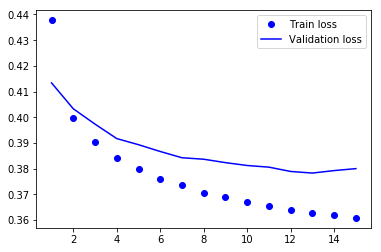

In [35]:
eval_metric(history, 'loss')

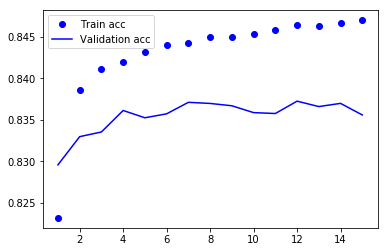

In [36]:
eval_metric(history, 'acc')

In [37]:
np.set_printoptions(threshold=np.inf)
y_pred = model.predict_classes(X_test)

In [38]:
print("Shape of y_pred: ",y_pred.shape)

Shape of y_pred:  (66292,)


## Create Excel File

In [39]:
i=0;
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('submission.xlsx')
worksheet = workbook.add_worksheet()

for label in y_pred:
    phraseid=testdf['PhraseId'][i];
    worksheet.write(i, 1, label) 
    worksheet.write(i, 0, phraseid)
    i=i+1;
    
workbook.close() 